# 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda

# 데이터 불러오기

깃허브에서 가져오기(구글 코랩 환경)

In [ ]:
os.chdir('../home')
os.getcwd()

'/home'

In [ ]:
!git clone https://github.com/HCturtle/pokemon-type.git

Cloning into 'pokemon-type'...
remote: Enumerating objects: 1748, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1748 (delta 0), reused 0 (delta 0), pack-reused 1741
Receiving objects: 100% (1748/1748), 42.37 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (39/39), done.


타입이 적혀있는 csv 파일 가져오기

In [ ]:
csv_data = pd.read_csv("./pokemon-type/data/pokemon.csv")
csv_data.info

<bound method DataFrame.info of             Name     Type1   Type2
0      bulbasaur     Grass  Poison
1        ivysaur     Grass  Poison
2       venusaur     Grass  Poison
3     charmander      Fire     NaN
4     charmeleon      Fire     NaN
..           ...       ...     ...
804    stakataka      Rock   Steel
805  blacephalon      Fire   Ghost
806      zeraora  Electric     NaN
807       meltan     Steel     NaN
808     melmetal     Steel     NaN

[809 rows x 3 columns]>

이미지 데이터 목록을 가져와 타입을 찾아서 pandas.DataFrame으로 만들기

In [ ]:
#train, validation 용 데이터
images_data = "./pokemon-type/data/images/"

In [ ]:
pokemon_filenames = os.listdir(images_data)

pnames, primary_types,secondary_types = [], [], []
for path in os.listdir(images_data):
        pokemon_name = path.split('.')[0] #'이름(영어버전).확장자' -> '이름(영어버전)'
        row = csv_data[csv_data['Name']==pokemon_name] #이름으로 해당 포켓몬 찾기
        type1 = csv_data['Type1'][int(row.index.values)]
        type2 = csv_data['Type2'][int(row.index.values)]
        pnames.append(pokemon_name.capitalize())#ex) abomasnow -> Abomasnow
        primary_types.append(type1)  
        secondary_types.append(type2)
#포켓몬 데이터 pandas.DataFrame 생성
pokemon_d = {'Image':pokemon_filenames, 'Pokemon':pnames, 'Primary_Type':primary_types, 'Secondary_Type':secondary_types}
pokemon_data = pd.DataFrame(pokemon_d)
pokemon_data['Primary_Type'].value_counts()

Water       114
Normal      105
Grass        78
Bug          72
Psychic      53
Fire         53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: Primary_Type, dtype: int64

In [ ]:
pokemon_data.head()

,Image,Pokemon,Primary_Type,Secondary_Type
0,volcarona.png,Volcarona,Bug,Fire
1,grovyle.png,Grovyle,Grass,NaN
2,gengar.png,Gengar,Ghost,Poison
3,florges.png,Florges,Fairy,NaN
4,spoink.png,Spoink,Psychic,NaN


In [ ]:
#포켓몬 번호 입력(csv_data의 순서가 포켓몬 도감 순서이다.)
numbers = []
for i in range(1,csv_data.shape[0]+1):
    numbers.append(i)
csv_data['pkn'] = numbers
#test 용 데이터
IMG_DIR = './pokemon-type/data/images_png'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]

import re
dataframe_img = pd.DataFrame([])
images = []
pokemon_number = []
for img in onlyfiles:
    if not re.search('-', img):
        pkn = img.split('.')
        n = re.sub("[^0-9]", "", pkn[0])
        path = str(img)
        images.append(path)
        pokemon_number.append(n)
dataframe_img['Image'] = images
dataframe_img['pkn'] = pokemon_number
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
#포켓몬 test 데이터 셋
pokemon_test = csv_data.merge(dataframe_img, left_on='pkn', right_on='pkn')
pokemon_test.rename(columns={'Name':'Pokemon','Type1':'Primary_Type','Type2':'Secondary_Type'},inplace=True)
pokemon_test['Primary_Type'].value_counts()

Water       103
Normal       91
Grass        64
Bug          61
Fire         47
Psychic      46
Rock         41
Electric     35
Ground       29
Dark         28
Poison       28
Fighting     25
Dragon       24
Ice          23
Ghost        22
Steel        22
Fairy        17
Flying        2
Name: Primary_Type, dtype: int64

# <b>전체 데이터로 수행</b>

## train, validation, test 분리

In [ ]:
#디렉토리 삭제
import shutil
if os.path.exists('train/'):
    shutil.rmtree('train/') 
if os.path.exists('test/'):
    shutil.rmtree('test/') 
if os.path.exists('val/'):
    shutil.rmtree('val/') 

#디렉토리 생성
from shutil import copyfile, copy2
if not os.path.exists('train/'):
    os.mkdir('train/')
if not os.path.exists('test/'):
    os.mkdir('test/')
if not os.path.exists('val/'):
    os.mkdir('val/')

#타입별 디렉토리 생성
for class_ in pokemon_data['Primary_Type'].unique():
    if not os.path.exists('train/'+str(class_)+'/'):
        os.mkdir('train/'+str(class_)+'/')
    if not os.path.exists('test/'+str(class_)+'/'):
        os.mkdir('test/'+str(class_)+'/')
    if not os.path.exists('val/'+str(class_)+'/'):
        os.mkdir('val/'+str(class_)+'/')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    pokemon_data, pokemon_data['Primary_Type'],test_size=0.33, stratify=pokemon_data['Primary_Type'], random_state=0)

X_test, y_test = pokemon_test, pokemon_test['Primary_Type']

In [ ]:
for image,type_  in zip(images_data +'/' + X_train['Image'], y_train):
    copy2(image, 'train/'+type_)

for image,type_ in zip(IMG_DIR +'/' + X_test['Image'], y_test):
    copy2(image, 'test/'+type_)
    
for image,type_ in zip(images_data +'/' + X_val['Image'], y_val):
    copy2(image, 'val/'+type_)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(542, 4)
(708, 5)
(267, 4)


In [ ]:
datagen = ImageDataGenerator()

train = datagen.flow_from_directory('train/')
test = datagen.flow_from_directory('test/')
val = datagen.flow_from_directory('val/')

Found 542 images belonging to 18 classes.
Found 708 images belonging to 18 classes.
Found 267 images belonging to 18 classes.


## 모델 만들기 및 학습

In [ ]:
def build(print_opt=True):
    model = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3 

    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(18, activation='softmax')) 
    
    if print_opt:
      model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer= "adam", metrics=['accuracy'])
    
    return model

모델 학습

In [ ]:
model = build()
history = model.fit(train, epochs=25, validation_data=val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 82, 82, 64)        2

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/25
17/17 [==============================] - 51s 165ms/step - loss: 4.5530 - accuracy: 0.0581 - val_loss: 16.2950 - val_accuracy: 0.0562
Epoch 2/25
17/17 [==============================] - 1s 84ms/step - loss: 3.0582 - accuracy: 0.1938 - val_loss: 7.5204 - val_accuracy: 0.0637
Epoch 3/25
17/17 [==============================] - 1s 85ms/step - loss: 2.7768 - accuracy: 0.1872 - val_loss: 4.3115 - val_accuracy: 0.0899
Epoch 4/25
17/17 [==============================] - 1s 85ms/step - loss: 2.4183 - accuracy: 0.2902 - val_loss: 3.5337 - val_accuracy: 0.0899
Epoch 5/25
17/17 [==============================] - 1s 86ms/step - loss: 2.1537 - accuracy: 0.3869 - val_loss: 3.1825 - val_accuracy: 0.1086
Epoch 6/25
17/17 [==============================] - 1s 84ms/step - loss: 1.8263 - accuracy: 0.4737 - val_loss: 3.0580 - val_accuracy: 0.1498
Epoch 7/25
17/17 [==============================] - 1s 84ms/step - loss: 1.7939 - accuracy: 0.4970 - val_loss: 2.9634 - val_accuracy: 0.1498
Epoch 8/25

## 학습 결과

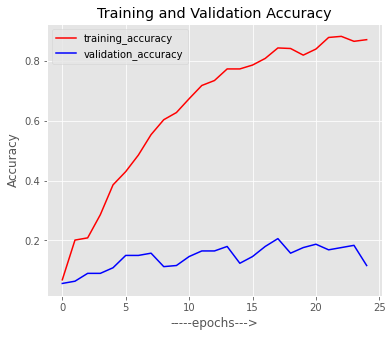

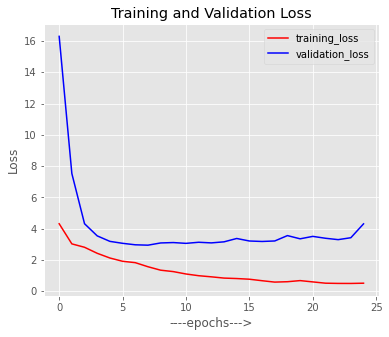

In [ ]:
plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()

## test 데이터 셋으로 예측

In [ ]:
predict = model.predict(test)

In [ ]:
from sklearn.metrics import classification_report
predict_frame = pd.DataFrame([])
predict_frame['category'] = np.argmax(predict, axis=-1)#test 예측값
labels = dict((v,k) for k,v in val.class_indices.items())#ex) ('Bug',0) -> (0,'Bug')
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))#y_test는 실제 테스트 데이터의 라벨

              precision    recall  f1-score   support

         Bug       0.06      0.07      0.06        61
        Dark       0.00      0.00      0.00        28
      Dragon       0.00      0.00      0.00        24
    Electric       0.00      0.00      0.00        35
       Fairy       0.00      0.00      0.00        17
    Fighting       0.00      0.00      0.00        25
        Fire       0.06      0.04      0.05        47
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00        22
       Grass       0.07      0.03      0.04        64
      Ground       0.08      0.10      0.09        29
         Ice       0.03      0.04      0.04        23
      Normal       0.10      0.07      0.08        91
      Poison       0.02      0.07      0.03        28
     Psychic       0.13      0.13      0.13        46
        Rock       0.06      0.10      0.07        41
       Steel       0.03      0.27      0.06        22
       Water       0.13    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
select = ['Water', 'Electric', 'Fire']
pokemon_test1 = pokemon_test[pokemon_test['Primary_Type'].isin(select)]#테스트 셋 분할
pokemon_data1 = pokemon_data[pokemon_data['Primary_Type'].isin(select)]#데이터 셋(train, validation) 분할
print(pokemon_data1['Primary_Type'].value_counts())
print(pokemon_test1['Primary_Type'].value_counts())

Water       114
Fire         53
Electric     40
Name: Primary_Type, dtype: int64
Water       103
Fire         47
Electric     35
Name: Primary_Type, dtype: int64


# <b>분할 데이터로 수행  </b>
Water, Electric, Fire만 이용해보기!

데이터 디렉토리 초기화

In [ ]:
if os.path.exists('strain/'):
    shutil.rmtree('strain/')
if os.path.exists('stest/'):
    shutil.rmtree('stest/')
if os.path.exists('sval/'):
    shutil.rmtree('sval/') 
    
from shutil import copyfile, copy2
if not os.path.exists('strain/'):
    os.mkdir('strain/')
if not os.path.exists('stest/'):
    os.mkdir('stest/')
if not os.path.exists('sval/'):
    os.mkdir('sval/')

for class_ in pokemon_data1['Primary_Type'].unique():
    if not os.path.exists('strain/'+str(class_)+'/'):
        os.mkdir('strain/'+str(class_)+'/')
    if not os.path.exists('stest/'+str(class_)+'/'):
        os.mkdir('stest/'+str(class_)+'/')
    if not os.path.exists('sval/'+str(class_)+'/'):
        os.mkdir('sval/'+str(class_)+'/')

## train, validation, test 분리

In [ ]:
X_strain, X_sval, y_strain, y_sval = train_test_split(
    pokemon_data1, pokemon_data1['Primary_Type'],test_size=0.33, stratify=pokemon_data1['Primary_Type'],random_state=0)

X_stest, y_stest = pokemon_test1, pokemon_test1['Primary_Type']
X_strain

,Image,Pokemon,Primary_Type,Secondary_Type
602,crawdaunt.png,Crawdaunt,Water,Dark
65,heatmor.png,Heatmor,Fire,NaN
144,poliwhirl.png,Poliwhirl,Water,NaN
51,magikarp.png,Magikarp,Water,NaN
620,blaziken.png,Blaziken,Fire,Fighting
...,...,...,...,...
137,wartortle.png,Wartortle,Water,NaN
293,dewgong.png,Dewgong,Water,Ice
761,voltorb.png,Voltorb,Electric,NaN
743,simisear.png,Simisear,Fire,NaN


In [ ]:
for image,type_  in zip(images_data +'/' + X_strain['Image'], y_strain):
    copy2(image, 'strain/'+type_)

for image,type_ in zip(IMG_DIR +'/' + X_stest['Image'], y_stest):
    copy2(image, 'stest/'+type_)
    
for image,type_ in zip(images_data +'/' + X_sval['Image'], y_sval):
    copy2(image, 'sval/'+type_)
y_stest

3          Fire
4          Fire
5          Fire
6         Water
7         Water
         ...   
679       Water
680    Electric
681    Electric
688    Electric
707        Fire
Name: Primary_Type, Length: 185, dtype: object

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen1 = ImageDataGenerator()

strain = datagen1.flow_from_directory('strain/')
stest = datagen1.flow_from_directory('stest/')
sval = datagen1.flow_from_directory('sval/')

Found 138 images belonging to 3 classes.
Found 185 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


## 모델 만들기 및 학습

In [ ]:
def build1(print_opt=True):
    model1 = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3

    model1.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    
    model1.add(Conv2D(32, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(3, 3))) 
    model1.add(Dropout(0.3))
    
    model1.add(Conv2D(64, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(3, 3)))
    model1.add(Dropout(0.3))
    
    model1.add(Conv2D(128, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(3, 3)))
    model1.add(Dropout(0.3))
    
    model1.add(Flatten())
    model1.add(Dense(512, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))
    model1.add(Dense(3, activation='softmax'))
    
    if print_opt:
      model1.summary()
    
    model1.compile(loss='categorical_crossentropy', optimizer= "adam", metrics=['accuracy'])
    
    return model1

In [ ]:
model1 = build1(print_opt=False)
history1 = model1.fit(strain, epochs=25, validation_data=sval)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/25
5/5 [==============================] - 3s 320ms/step - loss: 2.1214 - accuracy: 0.3187 - val_loss: 8.3345 - val_accuracy: 0.4783
Epoch 2/25
5/5 [==============================] - 0s 89ms/step - loss: 1.4993 - accuracy: 0.5220 - val_loss: 17.0320 - val_accuracy: 0.2609
Epoch 3/25
5/5 [==============================] - 0s 90ms/step - loss: 0.9797 - accuracy: 0.6242 - val_loss: 21.3280 - val_accuracy: 0.2754
Epoch 4/25
5/5 [==============================] - 0s 83ms/step - loss: 0.8597 - accuracy: 0.6224 - val_loss: 15.1990 - val_accuracy: 0.3043
Epoch 5/25
5/5 [==============================] - 0s 88ms/step - loss: 0.5504 - accuracy: 0.7705 - val_loss: 8.0941 - val_accuracy: 0.2754
Epoch 6/25
5/5 [==============================] - 0s 91ms/step - loss: 0.6888 - accuracy: 0.7377 - val_loss: 6.7877 - val_accuracy: 0.3333
Epoch 7/25
5/5 [==============================] - 0s 86ms/step - loss: 0.5943 - accuracy: 0.7391 - val_loss: 5.8995 - val_accuracy: 0.3333
Epoch 8/25
5/5 [=======

## 학습 결과

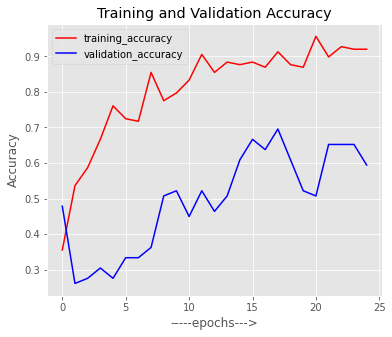

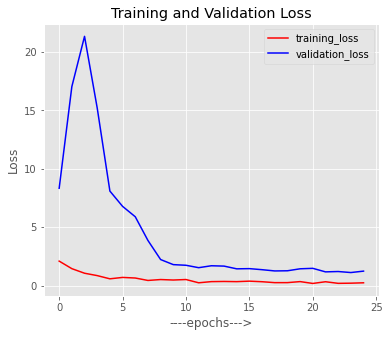

In [ ]:
plt.style.use('ggplot')

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()

## test 데이터 셋으로 예측

In [ ]:
predict1 = model1.predict(stest)

In [ ]:
from sklearn.metrics import classification_report
predict_frame1 = pd.DataFrame([])
predict_frame1['category'] = np.argmax(predict1, axis=-1)
labels = dict((v,k) for k,v in sval.class_indices.items())
predict_frame1['category'] = predict_frame1['category'].replace(labels)
print(classification_report(y_stest, predict_frame1['category']))

              precision    recall  f1-score   support

    Electric       0.15      0.11      0.13        35
        Fire       0.26      0.30      0.28        47
       Water       0.55      0.56      0.56       103

    accuracy                           0.41       185
   macro avg       0.32      0.33      0.32       185
weighted avg       0.40      0.41      0.41       185



## 오답 체크(분할 데이터)

In [ ]:
def show_wrong_classification(y_stest, predict1, pokemon_test1):
    tmp = pokemon_test1[pokemon_test1.index.isin(y_stest.index)]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
    i=0
    for imag, true, pred in zip(IMG_DIR +'/' + tmp['Image'], tmp['Primary_Type'], predict1):
        if true!=pred:
            if i < 4:
                img = Image.open(imag)
                fig = plt.figure()
                ax[i].imshow(img)
                ax[i].set_title('Actual:'+str(true)+'\n'+'predict:'+ str(pred))
                i+=1

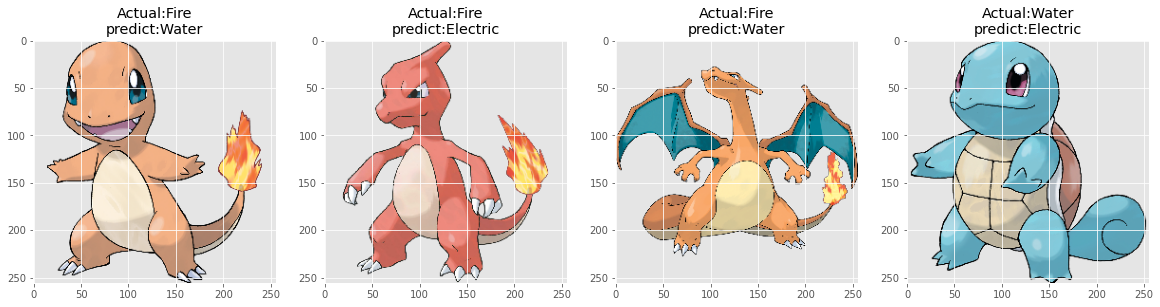

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
show_wrong_classification(y_stest, predict_frame1['category'], pokemon_test1)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) o

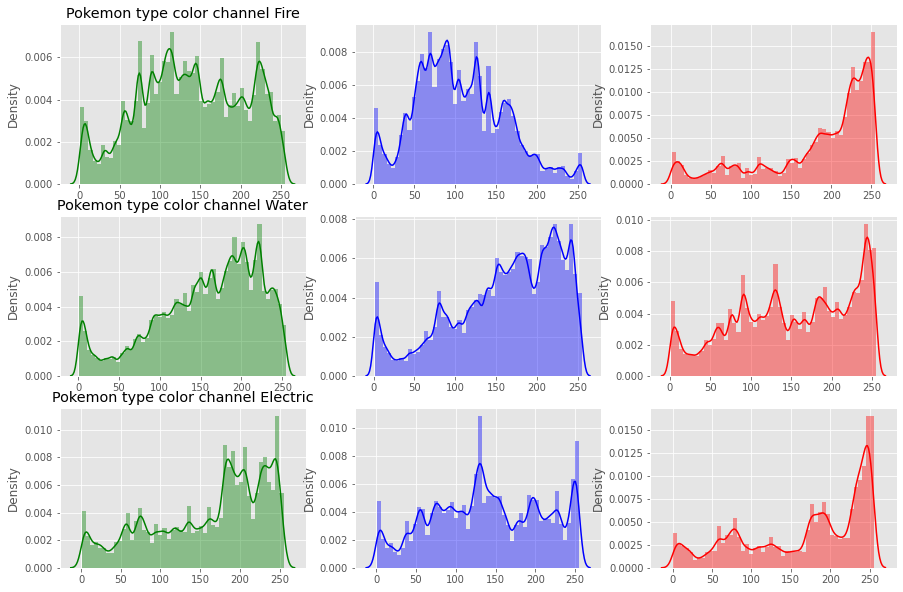

In [ ]:
#3개의 RGB채널에 픽셀의 분포
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,3,figsize=(15,10))
k =0
import cv2
list_b =[]
list_r = []
list_g = []
from tqdm import tqdm #작업 표시줄
for type_ in tqdm(pokemon_test1['Primary_Type'].unique()):
    tmp = pokemon_test1[pokemon_test1['Primary_Type']==type_]
    for img in IMG_DIR +'/' + tmp['Image']:
        img = cv2.imread(img)
        b, g, r = cv2.split(img)
        color = 'blue'
        for i in b:
            for j in i:
                if j != 0:
                    list_b.append(j)
        color = 'green'
        for i in g:
            for j in i:
                if j != 0:
                    list_g.append(j)
        color = 'red'
        for i in r:
            for j in i:
                if j != 0:
                    list_r.append(j)
    sns.distplot(list_g, ax=axes[k, 0], color='g')
    sns.distplot(list_b, ax=axes[k, 1], color='b')
    sns.distplot(list_r, ax=axes[k, 2], color='r')
    axes[k, 0].set_title('Pokemon type color channel ' + type_)
    if type_ =='Fire':
        list_g_f = list_g
        list_b_f = list_b
        list_r_f = list_r
    elif type_=='Water':
        list_g_w = list_g
        list_b_w = list_b
        list_r_w = list_r
    else:
        list_g_e = list_g
        list_b_e = list_b
        list_r_e = list_r
    list_b =[]
    list_r = []
    list_g = []
    
    k += 1

In [ ]:
predict1

array([[4.0666324e-01, 5.9306121e-01, 2.7556965e-04]], dtype=float32)

Text(0.5, 1.0, 'Actual: Electric\nPredict: Electric')

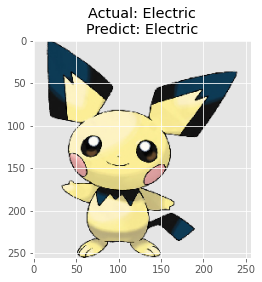

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

num=171 #예측할 포켓몬 번호

img = Image.open(IMG_DIR +'/' + X_test['Image'][num])#표시할 포켓몬 그림
img1 = load_img(IMG_DIR +'/' + X_test['Image'][num])#모델에 넣을 포켓몬 그림
data = img_to_array(img1)
samples = expand_dims(data, 0)#(256,256,3) -> (1,256,256,3)

predict1 = model1.predict(samples)#주의! model1을 이용하기 때문에 반드시 첫 속성이 Water, Electric, Fire 중 하나여야함!
predict_frame1 = pd.DataFrame([])
predict_frame1['category'] = np.argmax(predict1, axis=-1)
labels = dict((v,k) for k,v in sval.class_indices.items())

predict_frame1['category'] = predict_frame1['category'].replace(labels)
pred=predict_frame1['category'][0]
true=X_test['Primary_Type'][num]

fig = plt.figure()
plt.imshow(img)
plt.title('Actual: ' + str(true) + '\n' + 'Predict: ' + str(pred))

# <b>Gray Scale 이용하기(분할 데이터)</b>

## train, validation, test 분리

In [ ]:
#분할 데이터의 키 부여
TYPES = {
    0:"Water",
    1:"Electric",
    2:"Fire"}
key_list = list(TYPES.keys())
val_list = list(TYPES.values())
def replace_type(x):
    position = val_list.index(x)
    return key_list[position]

y_Strain = y_strain
y_Sval = y_sval
y_Stest = y_stest
y_Strain = y_Strain.apply(lambda x: replace_type(x))
y_Stest= y_Stest.apply(lambda x: replace_type(x))
y_Sval = y_Sval.apply(lambda x: replace_type(x))

## gray scale화

In [ ]:
from numpy import expand_dims

def imgGray_Lum(im1):
    imgarray1 = np.array(im1, dtype=np.float32)
    rows = im1.shape[0]
    cols = im1.shape[1]
    for i in range(rows):
        for j in range(cols):
            imgarray1[i, j, :] = (imgarray1[i, j, 0] * 0.299 + imgarray1[i, j, 1] * 0.587 + imgarray1[i, j, 2] * 0.114)
    return imgarray1.astype(np.uint8)#unit8 형식으로(uint8 : 부호 없는(unsigned) 8비트, 1바이트 정수)

In [ ]:
#train 셋
bs = list()

for imag,r in zip(X_strain['Image'],X_strain['Image'].index.values):
    I = Image.open(images_data +'/' + X_strain['Image'][r])
    I = I.resize((256,256),Image.ANTIALIAS)#안티앨리어싱(높은 해상도의 사진을 낮은 해상도로 변환할 때 깨진 패턴의 형태 최소화)
    I = I.convert('RGB')
    I = np.array(I)
    I = imgGray_Lum(I)

    bs.append(I[np.newaxis, :])
    data = np.concatenate(bs, axis=0)
    
#그룹화
X_Strain = np.empty((data.shape[0],256,256,3))
for i in range(data.shape[0]):
    X_Strain[i] = np.array(data[i])
y_Strain = np.array(y_Strain)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#validation 셋
bs1 = list()

for imag,r in zip(X_sval['Image'],X_sval['Image'].index.values):
    Iv = Image.open(images_data +'/' + X_sval['Image'][r])
    Iv = Iv.resize((256,256),Image.ANTIALIAS)#안티앨리어싱
    Iv = Iv.convert('RGB')
    Iv = np.array(Iv)
    Iv = imgGray_Lum(Iv)
    bs1.append(Iv[np.newaxis, :])
    data1 = np.concatenate(bs1, axis=0)
    
#그룹화
X_Sval = np.empty((data1.shape[0],256,256, 3))
for i in range(data1.shape[0]):
    X_Sval[i] = np.array(data1[i])   
y_Sval = np.array(y_Sval)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#test 셋
bs2 = list()

for imag,r in zip(X_stest['Image'],X_stest['Image'].index.values):
    Ie = Image.open(IMG_DIR+'/' + X_stest['Image'][r])
    #images_data와 달리, 이미 (256,256)의 크기이기 때문에 크기 조정 및 안티앨리어싱 필요 X
    Ie = Ie.convert('RGB')
    Ie = np.array(Ie)
    Ie = imgGray_Lum(Ie)
    bs2.append(Ie[np.newaxis, :])
    data2 = np.concatenate(bs2, axis=0)

#그룹화
X_Stest = np.empty((data2.shape[0],256,256,3))
for i in range(data2.shape[0]):
    X_Stest[i] = np.array(data2[i])   
y_Stest = np.array(y_Stest)

In [ ]:
print(y_Stest)

[2 2 2 0 0 0 1 1 2 2 0 0 2 2 0 0 0 0 0 2 2 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 1 2 0 0 0 0 1 2 1 2 2 2 2 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 2 2 0 0 0 0
 0 1 2 1 2 0 2 2 2 2 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 2 0 0 0 1 1 1 1 0 0 0 0 0 1 1 2 1 0 2 0 0 2 2 2 0 0 0 2 2 0 0
 1 1 0 0 0 2 0 0 0 0 1 0 0 0 0 0 1 1 1 2 2 2 2 0 0 0 2 2 2 2 2 0 0 1 1 1 2]


In [ ]:
X_Stest.shape

(185, 256, 256, 3)

## 모델 만들기 및 학습

In [ ]:
def build2(print_opt=True):
    model2 = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3 #Gray scale을 했지만, 아직 3채널로 존재함
    
    model2.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    
    model2.add(Conv2D(32, (3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(3, 3))) 
    model2.add(Dropout(0.3))
    
    model2.add(Conv2D(64, (3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(3, 3)))
    model2.add(Dropout(0.3))
    
    model2.add(Conv2D(128, (3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(3, 3)))
    model2.add(Dropout(0.3))
    
    model2.add(Flatten())
    model2.add(Dense(512, activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))
    model2.add(Dense(3, activation='softmax'))
    
    if print_opt:
      model2.summary()
    
    model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer= "adam", metrics=['accuracy'])
    
    return model2

In [ ]:
model2 = build2(print_opt=False)
history2 =  model2.fit(X_Strain,y_Strain, epochs=25, validation_data=(X_Sval,y_Sval))

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


5/5 [==============================] - 2s 197ms/step - loss: 2.4524 - accuracy: 0.3178 - val_loss: 22.3470 - val_accuracy: 0.5217
Epoch 2/25
5/5 [==============================] - 0s 65ms/step - loss: 1.8597 - accuracy: 0.4823 - val_loss: 25.1849 - val_accuracy: 0.5362
Epoch 3/25
5/5 [==============================] - 0s 65ms/step - loss: 1.2877 - accuracy: 0.5597 - val_loss: 9.4239 - val_accuracy: 0.3913
Epoch 4/25
5/5 [==============================] - 0s 62ms/step - loss: 0.8952 - accuracy: 0.6279 - val_loss: 10.1431 - val_accuracy: 0.2464
Epoch 5/25
5/5 [==============================] - 0s 65ms/step - loss: 0.9210 - accuracy: 0.6290 - val_loss: 6.1112 - val_accuracy: 0.3478
Epoch 6/25
5/5 [==============================] - 0s 63ms/step - loss: 0.7905 - accuracy: 0.6501 - val_loss: 4.1954 - val_accuracy: 0.4928
Epoch 7/25
5/5 [==============================] - 0s 63ms/step - loss: 0.7932 - accuracy: 0.7358 - val_loss: 3.3536 - val_accuracy: 0.3913
Epoch 8/25
5/5 [==================

## 학습 결과

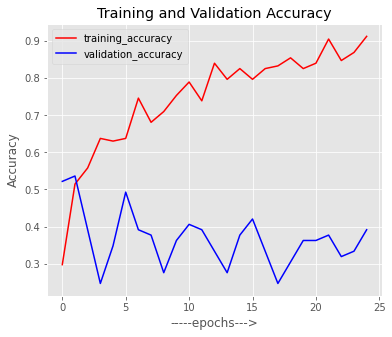

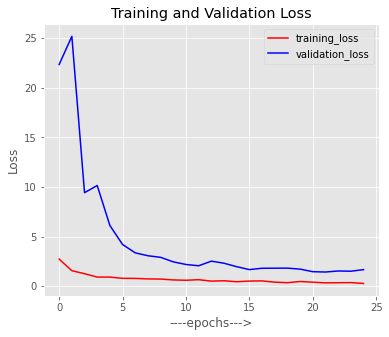

In [ ]:
plt.style.use('ggplot')
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()

## test 데이터 셋으로 예측

In [ ]:
predict3 = model2.predict(X_Stest)

from sklearn.metrics import classification_report
predict_frame3 = pd.DataFrame([])
predict_frame3['category'] = np.argmax(predict3, axis=-1)
labels2 = dict((v,k) for k,v in sval.class_indices.items())
predict_frame3['category'] = predict_frame3['category'].replace(labels2)
print(classification_report(y_stest, predict_frame3['category']))

              precision    recall  f1-score   support

    Electric       0.21      0.46      0.29        35
        Fire       0.34      0.55      0.42        47
       Water       0.70      0.22      0.34       103

    accuracy                           0.35       185
   macro avg       0.42      0.41      0.35       185
weighted avg       0.51      0.35      0.35       185



Text(0.5, 1.0, 'Actual: Electric\nPredict: Fire')

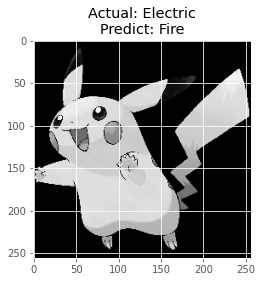

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

num = 6 #분할 데이터 중 6번째 포켓몬(피카츄)

im = X_Stest[num]
samples1 = expand_dims(im, 0)


predict2 = model2.predict(samples1)
predict_frame2 = pd.DataFrame([])
predict_frame2['category'] = np.argmax(predict2, axis=-1)
labels1 = dict((v,k) for k,v in sval.class_indices.items())

predict_frame2['category'] = predict_frame2['category'].replace(labels1)
pred1=predict_frame2['category'][0]
true1=TYPES[y_Stest[num]]

fig = plt.figure()
plt.imshow(im.astype("uint8"))
plt.title('Actual: ' + str(true1) + '\n' + 'Predict: ' + str(pred1))